# Import Libraries

In [90]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

In [2]:
import os
import torch
from torchvision import datasets,models, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import random
import matplotlib.pyplot as plt

# Read Labels CV

In [3]:
# read CSV
csv_path = 'image_labels_merged.csv'
df = pd.read_csv(csv_path, header=None, names=['image_name', 'label'])

# check data
print(df.head())

# Check the distribution of labels
print("distribution of labels:")
print(df['label'].value_counts())

# are there missing labels
missing_labels = df[df['label'].isnull()]
if not missing_labels.empty:
    print(f"null:\n{missing_labels}")
else:
    print("no missing label")


   image_name  label
0  asd_01.jpg      0
1  asd_02.jpg      0
2  asd_03.jpg      4
3  asd_04.jpg      2
4  asd_05.jpg      1
distribution of labels:
label
0    2067
4    1101
3     375
1     366
2     222
Name: count, dtype: int64
no missing label


# Create data with labels

## For create 20.000 data

In [156]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label from the dataset
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Default transformations for images
default_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Augmented transformations for data augmentation
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize to 224x224
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.RandomRotation(15),      # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),              # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Load the dataset from a CSV file
csv_file = 'image_labels_merged.csv'
img_dir = 'FADC-Dataset/All/'  # Directory containing images
original_data = pd.read_csv(csv_file, header=None, names=['image_name', 'label'])  # Read CSV with image names and labels

# Function to augment underrepresented classes in the dataset
def augment_data(data, class_label, multiplier):
    augmented_rows = []
    # Duplicate rows for the specified class
    for _, row in data[data['label'] == class_label].iterrows():
        for _ in range(multiplier - 1):  # Original data + (multiplier - 1) augmentations
            augmented_rows.append(row)
    return pd.DataFrame(augmented_rows, columns=data.columns)

# Augment specific classes (e.g., class 1, 2, 3)
augmented_rows = []
for class_label in [0]:  # Multiply class 0 by 2
    augmented_rows.append(augment_data(original_data, class_label, multiplier=2))
for class_label in [2]:  # Multiply class 2 by 5
    augmented_rows.append(augment_data(original_data, class_label, multiplier=5))
for class_label in [4, 5]:  # Multiply class 4 and 5 by 3
    augmented_rows.append(augment_data(original_data, class_label, multiplier=3))
for class_label in [1, 2, 3]:  # Multiply classes 1, 2, and 3 by 10
    augmented_rows.append(augment_data(original_data, class_label, multiplier=10))

# Combine all augmented rows into a single DataFrame
augmented_data = pd.concat(augmented_rows, ignore_index=True)

# Original dataset with default transformations
original_dataset = CustomImageDataset(data=original_data, img_dir=img_dir, transform=default_transform)

# Augmented dataset with augmented transformations
augmented_dataset = CustomImageDataset(data=augmented_data, img_dir=img_dir, transform=augmented_transform)

# Combine original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Split the combined dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))  # 80% for training
val_size = len(combined_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)    # Do not shuffle validation data

# Apply default transformation for the validation dataset
val_dataset.dataset.transform = default_transform

In [157]:
# Print class distribution for the original dataset
original_labels = original_data['label']
print("Original Dataset Class Counts:")
print(original_labels.value_counts())

# Print class distribution for the augmented dataset
augmented_labels = augmented_data['label']
print("\nAugmented Dataset Class Counts:")
print(augmented_labels.value_counts())

# Print class distribution for the combined dataset
combined_labels = pd.concat([original_labels, augmented_labels], ignore_index=True)
print("\nCombined Dataset Class Counts:")
print(combined_labels.value_counts())


Original Dataset Class Counts:
label
0    2067
4    1101
3     375
1     366
2     222
Name: count, dtype: int64

Augmented Dataset Class Counts:
label
3    3375
1    3294
2    2886
4    2202
0    2067
Name: count, dtype: int64

Combined Dataset Class Counts:
label
0    4134
3    3750
1    3660
4    3303
2    3108
Name: count, dtype: int64


### Result        
             precision   recall   f1-score   support
    Happy       0.80      0.65      0.71       804
    Sad         0.53      0.67      0.59       781
    Angry       0.57      0.77      0.65       643
    Suprised    0.82      0.34      0.48       749
    Neutral     0.41      0.52      0.46       614

    accuracy     --        --       0.59      3591
    macro avg   0.63      0.59      0.58      3591
    weightedavg 0.64      0.59      0.58      3591


Result with 10 epochs

             Loss    Accuracy   Precision   Recall   F1-Score
    Train   1.0222    59.48%      0.59       0.59      0.59
    Val     1.0641    58.70%      0.64       0.59      0.58

## For 10.000 data create

In [4]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label from the dataset
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Default transformations for images
default_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Augmented transformations for data augmentation
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize to 224x224
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.RandomRotation(15),      # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),              # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Load the dataset from a CSV file
csv_file = 'image_labels_merged.csv'
img_dir = 'FADC-Dataset/All/'  # Directory containing images
original_data = pd.read_csv(csv_file, header=None, names=['image_name', 'label'])  # Read CSV with image names and labels

# Function to augment underrepresented classes in the dataset
def augment_data(data, class_label, multiplier):
    augmented_rows = []
    # Duplicate rows for the specified class
    for _, row in data[data['label'] == class_label].iterrows():
        for _ in range(multiplier - 1):  # Original data + (multiplier - 1) augmentations
            augmented_rows.append(row)
    return pd.DataFrame(augmented_rows, columns=data.columns)

# Augment specific classes (e.g., class 1, 2, 3)
augmented_rows = []
for class_label in [2]:  # Multiply class 2 by 5
    augmented_rows.append(augment_data(original_data, class_label, multiplier=5))
for class_label in [4, 5]:  # Multiply class 4 and 5 by 3
    augmented_rows.append(augment_data(original_data, class_label, multiplier=2))
for class_label in [1, 2, 3]:  # Multiply classes 1, 2, and 3 by 10
    augmented_rows.append(augment_data(original_data, class_label, multiplier=5))

# Combine all augmented rows into a single DataFrame
augmented_data = pd.concat(augmented_rows, ignore_index=True)

# Original dataset with default transformations
original_dataset = CustomImageDataset(data=original_data, img_dir=img_dir, transform=default_transform)

# Augmented dataset with augmented transformations
augmented_dataset = CustomImageDataset(data=augmented_data, img_dir=img_dir, transform=augmented_transform)

# Combine original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Split the combined dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))  # 80% for training
val_size = len(combined_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,pin_memory=True)# Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,pin_memory=True)# Do not shuffle validation data


# Apply default transformation for the validation dataset
val_dataset.dataset.transform = default_transform

In [15]:
# Print class distribution for the original dataset
original_labels = original_data['label']
print("Original Dataset Class Counts:")
print(original_labels.value_counts())

# Print class distribution for the augmented dataset
augmented_labels = augmented_data['label']
print("\nAugmented Dataset Class Counts:")
print(augmented_labels.value_counts())

# Print class distribution for the combined dataset
combined_labels = pd.concat([original_labels, augmented_labels], ignore_index=True)
print("\nCombined Dataset Class Counts:")
print(combined_labels.value_counts())

Original Dataset Class Counts:
label
0    2067
4    1101
3     375
1     366
2     222
Name: count, dtype: int64

Augmented Dataset Class Counts:
label
2    1776
3    1500
1    1464
4    1101
Name: count, dtype: int64

Combined Dataset Class Counts:
label
4    2202
0    2067
2    1998
3    1875
1    1830
Name: count, dtype: int64


              precision    recall  f1-score   support

       Happy       0.74      0.83      0.78       422
         Sad       0.42      0.62      0.50       341
       Angry       0.63      0.60      0.62       403
    Suprised       0.52      0.61      0.56       383
     Neutral       0.61      0.25      0.35       446

    accuracy        --        --       0.58      1995
    macro avg      0.58      0.58      0.56      1995
    weighted avg   0.59      0.58      0.56      1995

Result with 10 epochs

             Loss    Accuracy   Precision   Recall   F1-Score
    Train   1.0195    57.75%      0.57       0.58      0.57
    Val     1.0399    57.54%      0.59       0.58      0.56

# Visualize Original and Augmented Data

Random Samples from Original Dataset:


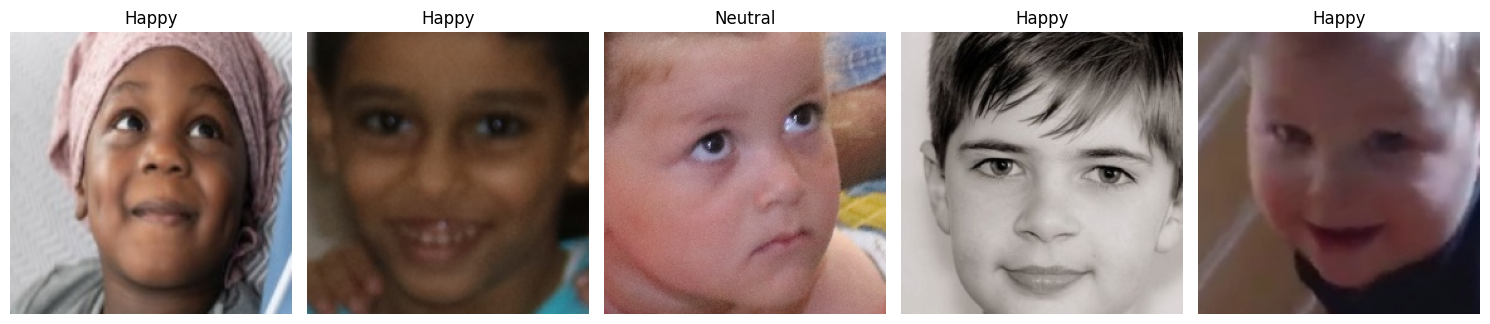

Random Samples from Augmented Dataset:


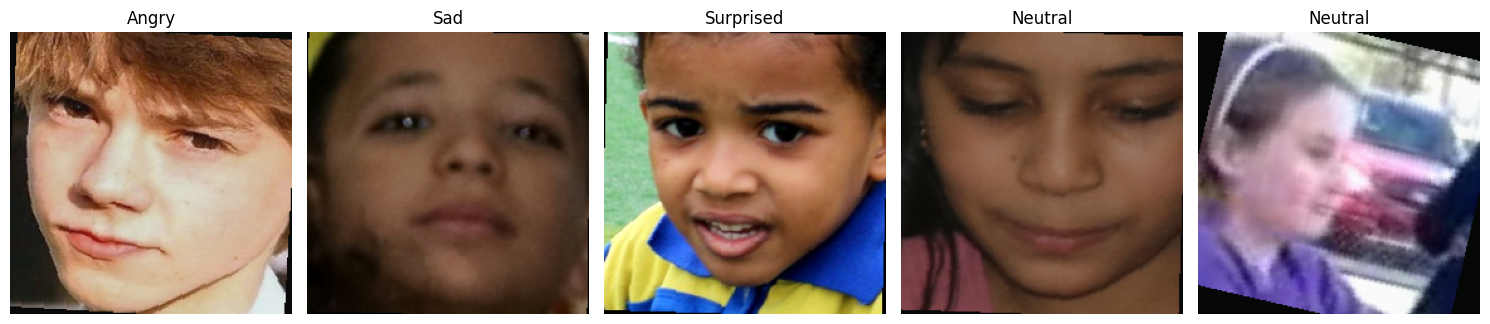

In [5]:
# Define class names
class_names = ["Happy", "Sad", "Angry", "Surprised", "Neutral"]
# Function to visualize random samples from a dataset
def visualize_random_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    random_indices = random.sample(range(len(dataset)), num_samples)  # Randomly select indices
    for i, idx in enumerate(random_indices):
        # Get the image and label at the random index
        image, label = dataset[idx]
        # Convert tensor image to numpy for visualization
        image = image.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
        image = image.clip(0, 1)  # Clip values to be between 0 and 1
        axes[i].imshow(image)
        axes[i].set_title(f"{class_names[label]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize random samples from the original dataset
print("Random Samples from Original Dataset:")
visualize_random_samples(original_dataset, num_samples=5)

# Visualize random samples from the augmented dataset
print("Random Samples from Augmented Dataset:")
visualize_random_samples(augmented_dataset, num_samples=5)


# Weights Calculation

In [6]:
# Get indices for the train dataset
train_indices = train_dataset.indices if hasattr(train_dataset, 'indices') else range(len(train_dataset))

# Get labels for the combined dataset corresponding to train indices
train_labels = [combined_dataset[i][1] for i in train_indices]  # Labels for the specified indices

# Recalculate class counts
class_counts = pd.Series(train_labels).value_counts().sort_index()  # Count occurrences of each class
class_weights = 1. / class_counts  # Calculate weights for each class (inverse of the count)
sample_weights = [class_weights[label] for label in train_labels]  # Assign weights to each sample based on its label

# Use WeightedRandomSampler for balanced sampling
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader for training dataset with sampler
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, pin_memory=True)
# DataLoader for validation dataset (no sampler, no shuffle)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Model Creation Function

In [58]:
# Create model
class EmotionDetectionModel(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionDetectionModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze labels

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        for param in self.resnet.fc.parameters():
            param.requires_grad = True  # Trai only FC labels (last label)
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True 
 

    def forward(self, x):
        return self.resnet(x)

# Model Train Functions

In [8]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        
        # Forward Pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    # Calculate F1, Precision, and Recall
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1


def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Metrics
            total_loss += loss.item()
            total += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate F1, Precision, and Recall
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
all_labels_final = []
all_preds_final = []

In [84]:
def train_model(optimizer, criterion, scheduler, model, Printheader):
    train_losses.clear()
    val_losses.clear()
    train_accuracies.clear()
    val_accuracies.clear()
    train_f1_scores.clear()
    val_f1_scores.clear()
    all_preds_final.clear()
    all_labels_final.clear()
    # Training Loop
    for epoch in range(10):
        # Train
        train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion)
        
        # Validate
        val_loss, val_accuracy, val_precision, val_recall, val_f1, all_labels, all_preds = validate(model, val_loader, criterion)

        # update learning rate
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)
        # print classification report
        if epoch == 0:
            # Print metrics
            print(Printheader)
        if epoch == 9:
            all_preds_final.append(all_preds)
            all_labels_final.append(all_labels)
            print(classification_report(all_labels, all_preds, target_names=class_names))
        print(f"Epoch [{epoch+1}/10] , {train_losses}")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-Score: {train_f1:.2f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1-Score: {val_f1:.2f}")

# Finding best configration

## Train with different configurations

In [20]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        num_classes = inputs.size(1)
        one_hot = torch.zeros_like(inputs).scatter(1, targets.unsqueeze(1), 1)
        smoothed_labels = (1 - self.smoothing) * one_hot + self.smoothing / num_classes
        log_probs = nn.functional.log_softmax(inputs, dim=1)
        loss = -torch.sum(smoothed_labels * log_probs, dim=1).mean()
        return loss


In [120]:
class_names = ["Happy", "Sad", "Angry", "Surprised", "Neutral"]

# Loss functions
criterion_CEL = nn.CrossEntropyLoss()
criterion_LSL = LabelSmoothingLoss(smoothing=0.1)
criterion_list = [criterion_CEL, criterion_LSL]
criterion_name_list = ["CEL", "LSL"]

# Schedulers
scheduler_name_list = ["RLROP", "RLROP_max", "SLR"]

# Function to create model, optimizer, and scheduler
def create_model_optimizer_scheduler(lr, criterion, scheduler_type):
    model = EmotionDetectionModel(num_classes=5)
    model.to('cuda')
    optimizer = Adam(model.parameters(), lr=lr)

    if scheduler_type == "RLROP":
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    elif scheduler_type == "RLROP_max":
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    elif scheduler_type == "SLR":
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")

    return model, optimizer, scheduler

# Training loop
def train_with_configurations():
    for i, criterion in enumerate(criterion_list):
        for lr in [0.01, 0.001]:
            for scheduler_type in scheduler_name_list:
                model, optimizer, scheduler = create_model_optimizer_scheduler(lr, criterion, scheduler_type)
                train_model(
                    optimizer,
                    criterion,
                    scheduler,
                    model,
                    f"criterion {criterion_name_list[i]} / scheduler {scheduler_type} / LR {lr:.3f}"
                )

# Execute training
train_with_configurations()


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


criterion CEL / scheduler RLROP / LR 0.010
              precision    recall  f1-score   support

       Happy       0.79      0.68      0.73       436
         Sad       0.46      0.38      0.42       362
       Angry       0.72      0.27      0.39       394
   Surprised       0.32      0.89      0.48       361
     Neutral       0.49      0.20      0.28       442

    accuracy                           0.48      1995
   macro avg       0.56      0.48      0.46      1995
weighted avg       0.57      0.48      0.46      1995

Epoch [1/10]
  Train Loss: 2.0454, Accuracy: 42.07%, Precision: 0.42, Recall: 0.42, F1-Score: 0.42
  Val Loss: 1.5237, Accuracy: 47.62%, Precision: 0.57, Recall: 0.48, F1-Score: 0.46
criterion CEL / scheduler RLROP / LR 0.010
              precision    recall  f1-score   support

       Happy       0.79      0.68      0.73       436
         Sad       0.65      0.34      0.44       362
       Angry       0.72      0.53      0.61       394
   Surprised       0.62  

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


criterion CEL / scheduler RLROP_max / LR 0.010
              precision    recall  f1-score   support

       Happy       0.42      1.00      0.59       436
         Sad       0.43      0.38      0.40       362
       Angry       0.68      0.24      0.36       394
   Surprised       0.50      0.39      0.44       361
     Neutral       0.24      0.13      0.17       442

    accuracy                           0.43      1995
   macro avg       0.46      0.43      0.39      1995
weighted avg       0.45      0.43      0.39      1995

Epoch [1/10]
  Train Loss: 1.8756, Accuracy: 42.87%, Precision: 0.42, Recall: 0.43, F1-Score: 0.43
  Val Loss: 1.8341, Accuracy: 43.26%, Precision: 0.45, Recall: 0.43, F1-Score: 0.39
criterion CEL / scheduler RLROP_max / LR 0.010
              precision    recall  f1-score   support

       Happy       0.81      0.83      0.82       436
         Sad       0.56      0.55      0.55       362
       Angry       0.60      0.73      0.66       394
   Surprised     

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: User

criterion CEL / scheduler SLR / LR 0.010
              precision    recall  f1-score   support

       Happy       0.81      0.68      0.74       436
         Sad       0.43      0.35      0.38       362
       Angry       0.89      0.12      0.21       394
   Surprised       0.28      0.92      0.43       361
     Neutral       0.54      0.11      0.18       442

    accuracy                           0.43      1995
   macro avg       0.59      0.43      0.39      1995
weighted avg       0.60      0.43      0.39      1995

Epoch [1/10]
  Train Loss: 1.8172, Accuracy: 41.97%, Precision: 0.42, Recall: 0.42, F1-Score: 0.42
  Val Loss: 1.7803, Accuracy: 42.56%, Precision: 0.60, Recall: 0.43, F1-Score: 0.39


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the d

criterion CEL / scheduler SLR / LR 0.010
              precision    recall  f1-score   support

       Happy       0.58      0.95      0.72       436
         Sad       0.58      0.54      0.56       362
       Angry       0.68      0.59      0.63       394
   Surprised       0.65      0.20      0.31       361
     Neutral       0.42      0.47      0.44       442

    accuracy                           0.56      1995
   macro avg       0.58      0.55      0.53      1995
weighted avg       0.58      0.56      0.54      1995

Epoch [10/10]
  Train Loss: 1.3716, Accuracy: 55.70%, Precision: 0.56, Recall: 0.56, F1-Score: 0.56
  Val Loss: 1.4766, Accuracy: 56.04%, Precision: 0.58, Recall: 0.56, F1-Score: 0.54
criterion CEL / scheduler RLROP / LR 0.001
              precision    recall  f1-score   support

       Happy       0.74      0.76      0.75       436
         Sad       0.51      0.31      0.38       362
       Angry       0.49      0.67      0.56       394
   Surprised       0.43   

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


criterion CEL / scheduler RLROP_max / LR 0.001
              precision    recall  f1-score   support

       Happy       0.74      0.70      0.72       436
         Sad       0.35      0.65      0.45       362
       Angry       0.65      0.37      0.47       394
   Surprised       0.44      0.43      0.44       361
     Neutral       0.45      0.33      0.38       442

    accuracy                           0.50      1995
   macro avg       0.52      0.50      0.49      1995
weighted avg       0.53      0.50      0.49      1995

Epoch [1/10]
  Train Loss: 1.3114, Accuracy: 43.89%, Precision: 0.42, Recall: 0.44, F1-Score: 0.43
  Val Loss: 1.1785, Accuracy: 49.52%, Precision: 0.53, Recall: 0.50, F1-Score: 0.49
criterion CEL / scheduler RLROP_max / LR 0.001
              precision    recall  f1-score   support

       Happy       0.69      0.90      0.78       436
         Sad       0.55      0.53      0.54       362
       Angry       0.64      0.55      0.59       394
   Surprised     

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: User

criterion CEL / scheduler SLR / LR 0.001
              precision    recall  f1-score   support

       Happy       0.57      0.95      0.72       436
         Sad       0.50      0.14      0.22       362
       Angry       0.41      0.73      0.52       394
   Surprised       0.55      0.29      0.38       361
     Neutral       0.44      0.28      0.34       442

    accuracy                           0.49      1995
   macro avg       0.49      0.48      0.44      1995
weighted avg       0.49      0.49      0.45      1995

Epoch [1/10]
  Train Loss: 1.3274, Accuracy: 43.05%, Precision: 0.42, Recall: 0.43, F1-Score: 0.42
  Val Loss: 1.1772, Accuracy: 49.17%, Precision: 0.49, Recall: 0.49, F1-Score: 0.45


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the d

criterion CEL / scheduler SLR / LR 0.001
              precision    recall  f1-score   support

       Happy       0.85      0.72      0.78       436
         Sad       0.39      0.76      0.51       362
       Angry       0.69      0.49      0.57       394
   Surprised       0.52      0.59      0.55       361
     Neutral       0.52      0.27      0.36       442

    accuracy                           0.56      1995
   macro avg       0.59      0.57      0.56      1995
weighted avg       0.60      0.56      0.56      1995

Epoch [10/10]
  Train Loss: 1.0537, Accuracy: 56.91%, Precision: 0.56, Recall: 0.57, F1-Score: 0.56
  Val Loss: 1.0798, Accuracy: 55.89%, Precision: 0.60, Recall: 0.56, F1-Score: 0.56
criterion LSL / scheduler RLROP / LR 0.010
              precision    recall  f1-score   support

       Happy       0.92      0.35      0.50       436
         Sad       0.86      0.03      0.06       362
       Angry       0.35      0.84      0.49       394
   Surprised       0.39   

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


criterion LSL / scheduler RLROP_max / LR 0.010
              precision    recall  f1-score   support

       Happy       0.67      0.87      0.76       436
         Sad       0.79      0.06      0.11       362
       Angry       0.47      0.75      0.58       394
   Surprised       0.44      0.53      0.48       361
     Neutral       0.45      0.34      0.38       442

    accuracy                           0.52      1995
   macro avg       0.56      0.51      0.46      1995
weighted avg       0.56      0.52      0.47      1995

Epoch [1/10]
  Train Loss: 1.9606, Accuracy: 41.48%, Precision: 0.41, Recall: 0.41, F1-Score: 0.41
  Val Loss: 1.4179, Accuracy: 51.93%, Precision: 0.56, Recall: 0.52, F1-Score: 0.47


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


criterion LSL / scheduler RLROP_max / LR 0.010
              precision    recall  f1-score   support

       Happy       0.75      0.82      0.78       436
         Sad       0.81      0.21      0.33       362
       Angry       0.78      0.40      0.53       394
   Surprised       0.30      0.98      0.46       361
     Neutral       0.73      0.04      0.08       442

    accuracy                           0.48      1995
   macro avg       0.67      0.49      0.44      1995
weighted avg       0.68      0.48      0.44      1995

Epoch [10/10]
  Train Loss: 1.2349, Accuracy: 57.93%, Precision: 0.58, Recall: 0.58, F1-Score: 0.58
  Val Loss: 1.7302, Accuracy: 48.27%, Precision: 0.68, Recall: 0.48, F1-Score: 0.44


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: User

criterion LSL / scheduler SLR / LR 0.010
              precision    recall  f1-score   support

       Happy       0.74      0.72      0.73       436
         Sad       0.58      0.10      0.17       362
       Angry       0.90      0.07      0.13       394
   Surprised       0.73      0.02      0.04       361
     Neutral       0.26      0.88      0.41       442

    accuracy                           0.39      1995
   macro avg       0.64      0.36      0.30      1995
weighted avg       0.64      0.39      0.31      1995

Epoch [1/10]
  Train Loss: 1.9415, Accuracy: 41.32%, Precision: 0.41, Recall: 0.41, F1-Score: 0.41
  Val Loss: 1.9008, Accuracy: 38.75%, Precision: 0.64, Recall: 0.39, F1-Score: 0.31


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the d

criterion LSL / scheduler SLR / LR 0.010
              precision    recall  f1-score   support

       Happy       0.98      0.30      0.46       436
         Sad       0.64      0.31      0.42       362
       Angry       0.71      0.51      0.59       394
   Surprised       0.65      0.34      0.45       361
     Neutral       0.31      0.85      0.45       442

    accuracy                           0.47      1995
   macro avg       0.66      0.46      0.47      1995
weighted avg       0.66      0.47      0.47      1995

Epoch [10/10]
  Train Loss: 1.4040, Accuracy: 56.14%, Precision: 0.56, Recall: 0.56, F1-Score: 0.56
  Val Loss: 1.6368, Accuracy: 47.02%, Precision: 0.66, Recall: 0.47, F1-Score: 0.47
criterion LSL / scheduler RLROP / LR 0.001
              precision    recall  f1-score   support

       Happy       0.64      0.90      0.75       436
         Sad       0.43      0.32      0.37       362
       Angry       0.50      0.63      0.56       394
   Surprised       0.43   

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


criterion LSL / scheduler RLROP_max / LR 0.001
              precision    recall  f1-score   support

       Happy       0.79      0.70      0.74       436
         Sad       0.55      0.19      0.28       362
       Angry       0.44      0.71      0.54       394
   Surprised       0.52      0.30      0.39       361
     Neutral       0.38      0.55      0.45       442

    accuracy                           0.50      1995
   macro avg       0.54      0.49      0.48      1995
weighted avg       0.54      0.50      0.49      1995

Epoch [1/10]
  Train Loss: 1.3862, Accuracy: 43.22%, Precision: 0.42, Recall: 0.43, F1-Score: 0.42
  Val Loss: 1.2684, Accuracy: 50.28%, Precision: 0.54, Recall: 0.50, F1-Score: 0.49
criterion LSL / scheduler RLROP_max / LR 0.001
              precision    recall  f1-score   support

       Happy       0.81      0.79      0.80       436
         Sad       0.54      0.53      0.54       362
       Angry       0.62      0.63      0.63       394
   Surprised     

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: User

criterion LSL / scheduler SLR / LR 0.001
              precision    recall  f1-score   support

       Happy       0.76      0.76      0.76       436
         Sad       0.78      0.05      0.09       362
       Angry       0.40      0.75      0.52       394
   Surprised       0.54      0.32      0.40       361
     Neutral       0.39      0.50      0.44       442

    accuracy                           0.49      1995
   macro avg       0.57      0.48      0.44      1995
weighted avg       0.57      0.49      0.45      1995

Epoch [1/10]
  Train Loss: 1.3818, Accuracy: 43.01%, Precision: 0.42, Recall: 0.43, F1-Score: 0.42
  Val Loss: 1.2847, Accuracy: 49.22%, Precision: 0.57, Recall: 0.49, F1-Score: 0.45


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the d

criterion LSL / scheduler SLR / LR 0.001
              precision    recall  f1-score   support

       Happy       0.87      0.67      0.76       436
         Sad       0.69      0.24      0.35       362
       Angry       0.53      0.71      0.61       394
   Surprised       0.61      0.22      0.33       361
     Neutral       0.36      0.70      0.47       442

    accuracy                           0.53      1995
   macro avg       0.61      0.51      0.50      1995
weighted avg       0.61      0.53      0.51      1995

Epoch [10/10]
  Train Loss: 1.1823, Accuracy: 57.45%, Precision: 0.57, Recall: 0.57, F1-Score: 0.57
  Val Loss: 1.2229, Accuracy: 52.63%, Precision: 0.61, Recall: 0.53, F1-Score: 0.51


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


## Visualization of training models

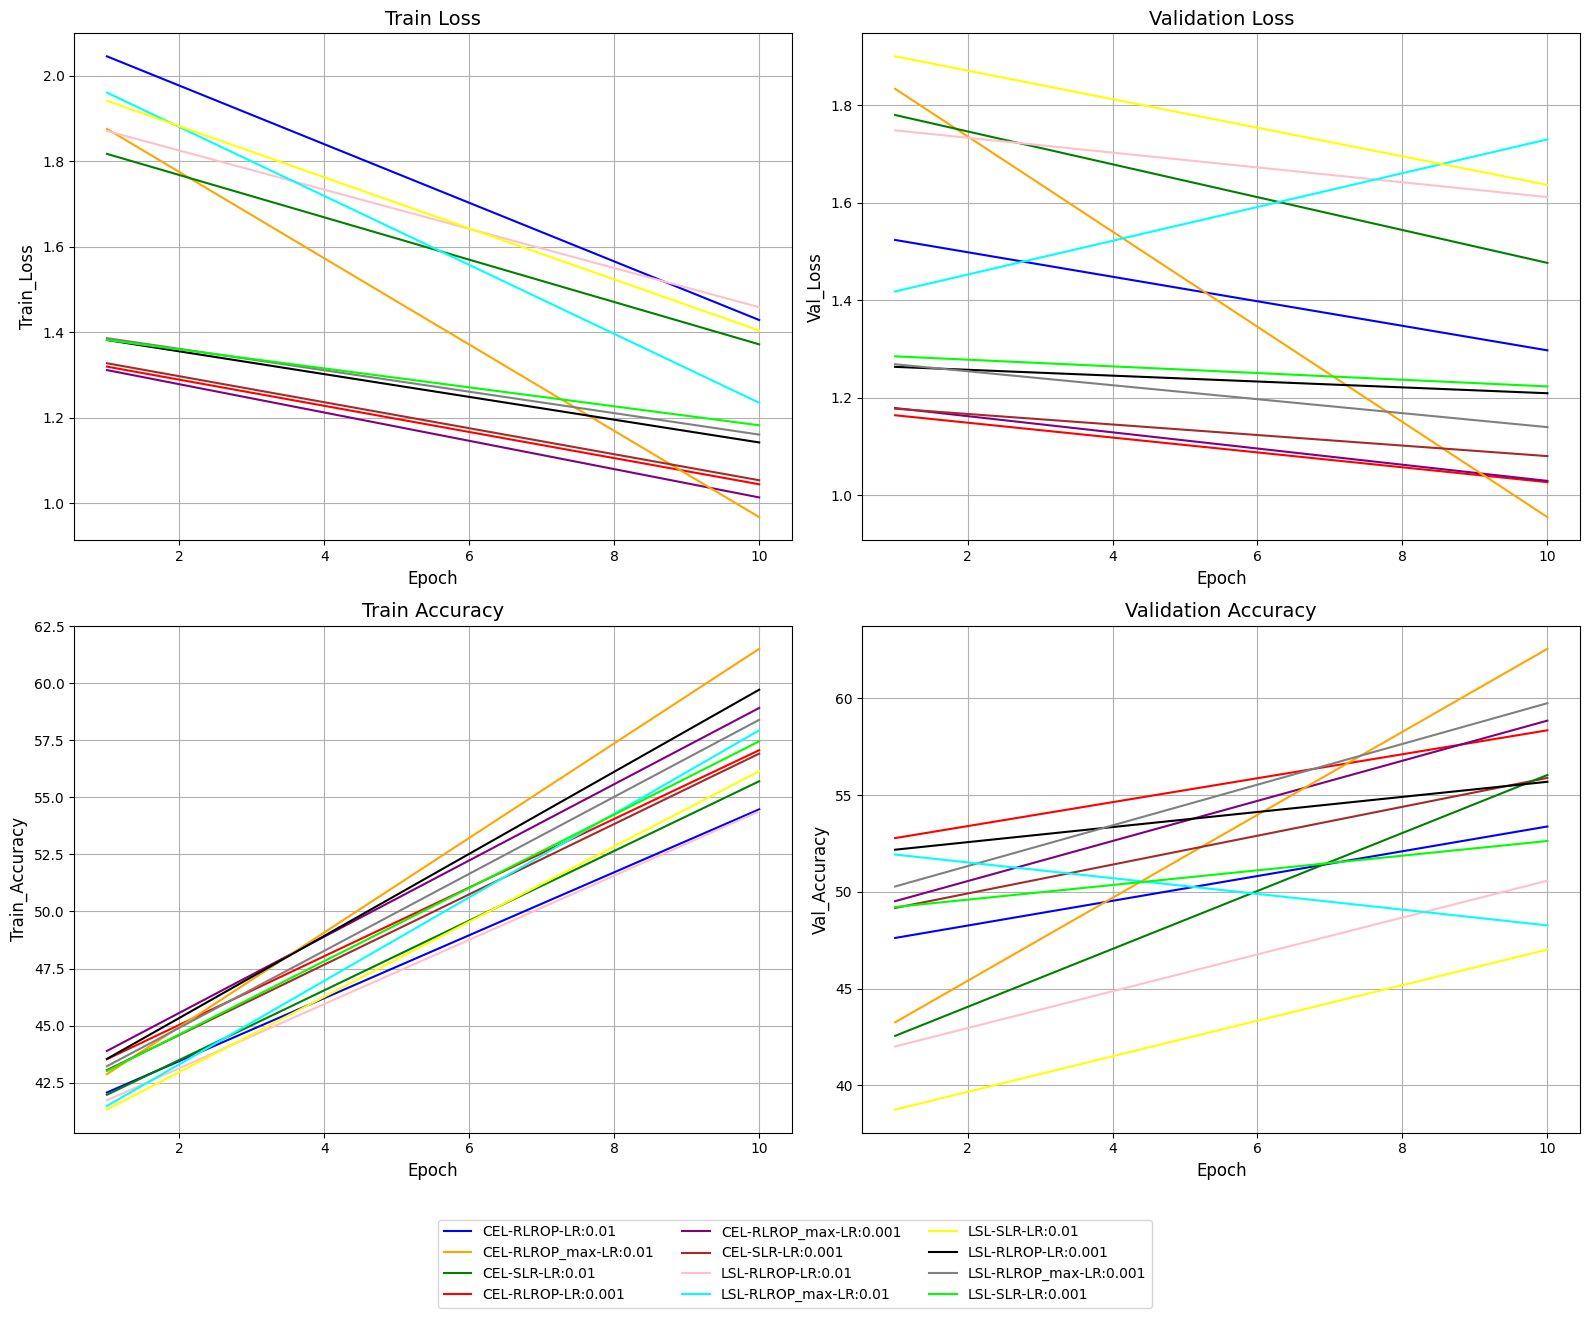

In [22]:
# Create Data
data = [
    {"Criterion": "CEL", "Scheduler": "RLROP", "LR": 0.01, "Epoch": 1, "Train_Loss": 2.0454, "Train_Accuracy": 42.07, "Val_Loss": 1.5237, "Val_Accuracy": 47.62},
    {"Criterion": "CEL", "Scheduler": "RLROP", "LR": 0.01, "Epoch": 10, "Train_Loss": 1.4285, "Train_Accuracy": 54.47, "Val_Loss": 1.2970, "Val_Accuracy": 53.38},
    {"Criterion": "CEL", "Scheduler": "RLROP_max", "LR": 0.01, "Epoch": 1, "Train_Loss": 1.8756, "Train_Accuracy": 42.87, "Val_Loss": 1.8341, "Val_Accuracy": 43.26},
    {"Criterion": "CEL", "Scheduler": "RLROP_max", "LR": 0.01, "Epoch": 10, "Train_Loss": 0.9674, "Train_Accuracy": 61.50, "Val_Loss": 0.9545, "Val_Accuracy": 62.56},
    {"Criterion": "CEL", "Scheduler": "SLR", "LR": 0.01, "Epoch": 1, "Train_Loss": 1.8172, "Train_Accuracy": 41.97, "Val_Loss": 1.7803, "Val_Accuracy": 42.56},
    {"Criterion": "CEL", "Scheduler": "SLR", "LR": 0.01, "Epoch": 10, "Train_Loss": 1.3716, "Train_Accuracy": 55.70, "Val_Loss": 1.4766, "Val_Accuracy": 56.04},
    {"Criterion": "CEL", "Scheduler": "RLROP", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3195, "Train_Accuracy": 43.53, "Val_Loss": 1.1637, "Val_Accuracy": 52.78},
    {"Criterion": "CEL", "Scheduler": "RLROP", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.0443, "Train_Accuracy": 57.06, "Val_Loss": 1.0263, "Val_Accuracy": 58.35},
    {"Criterion": "CEL", "Scheduler": "RLROP_max", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3114, "Train_Accuracy": 43.89, "Val_Loss": 1.1785, "Val_Accuracy": 49.52},
    {"Criterion": "CEL", "Scheduler": "RLROP_max", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.0135, "Train_Accuracy": 58.91, "Val_Loss": 1.0289, "Val_Accuracy": 58.85},
    {"Criterion": "CEL", "Scheduler": "SLR", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3274, "Train_Accuracy": 43.05, "Val_Loss": 1.1772, "Val_Accuracy": 49.17},
    {"Criterion": "CEL", "Scheduler": "SLR", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.0537, "Train_Accuracy": 56.91, "Val_Loss": 1.0798, "Val_Accuracy": 55.89},
    {"Criterion": "LSL", "Scheduler": "RLROP", "LR": 0.01, "Epoch": 1, "Train_Loss": 1.8709, "Train_Accuracy": 41.73, "Val_Loss": 1.7488, "Val_Accuracy": 42.01},
    {"Criterion": "LSL", "Scheduler": "RLROP", "LR": 0.01, "Epoch": 10, "Train_Loss": 1.4585, "Train_Accuracy": 54.38, "Val_Loss": 1.6117, "Val_Accuracy": 50.58},
    {"Criterion": "LSL", "Scheduler": "RLROP_max", "LR": 0.01, "Epoch": 1, "Train_Loss": 1.9606, "Train_Accuracy": 41.48, "Val_Loss": 1.4179, "Val_Accuracy": 51.93},
    {"Criterion": "LSL", "Scheduler": "RLROP_max", "LR": 0.01, "Epoch": 10, "Train_Loss": 1.2349, "Train_Accuracy": 57.93, "Val_Loss": 1.7302, "Val_Accuracy": 48.27},
    {"Criterion": "LSL", "Scheduler": "SLR", "LR": 0.01, "Epoch": 1, "Train_Loss": 1.9415, "Train_Accuracy": 41.32, "Val_Loss": 1.9008, "Val_Accuracy": 38.75},
    {"Criterion": "LSL", "Scheduler": "SLR", "LR": 0.01, "Epoch": 10, "Train_Loss": 1.4040, "Train_Accuracy": 56.14, "Val_Loss": 1.6368, "Val_Accuracy": 47.02},
    {"Criterion": "LSL", "Scheduler": "RLROP", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3818, "Train_Accuracy": 43.54, "Val_Loss": 1.2631, "Val_Accuracy": 52.18},
    {"Criterion": "LSL", "Scheduler": "RLROP", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.1421, "Train_Accuracy": 59.71, "Val_Loss": 1.2089, "Val_Accuracy": 55.69},
    {"Criterion": "LSL", "Scheduler": "RLROP_max", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3862, "Train_Accuracy": 43.22, "Val_Loss": 1.2684, "Val_Accuracy": 50.28},
    {"Criterion": "LSL", "Scheduler": "RLROP_max", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.1605, "Train_Accuracy": 58.39, "Val_Loss": 1.1393, "Val_Accuracy": 59.75},
    {"Criterion": "LSL", "Scheduler": "SLR", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3818, "Train_Accuracy": 43.01, "Val_Loss": 1.2847, "Val_Accuracy": 49.22},
    {"Criterion": "LSL", "Scheduler": "SLR", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.1823, "Train_Accuracy": 57.45, "Val_Loss": 1.2229, "Val_Accuracy": 52.63}
]

df = pd.DataFrame(data)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ["Train_Loss", "Val_Loss", "Train_Accuracy", "Val_Accuracy"]
titles = ["Train Loss", "Validation Loss", "Train Accuracy", "Validation Accuracy"]

# Same color as each metric
colors = {
    "CEL-RLROP-LR:0.01": "blue",
    "CEL-RLROP_max-LR:0.01": "orange",
    "CEL-SLR-LR:0.01": "green",
    "CEL-RLROP-LR:0.001": "red",
    "CEL-RLROP_max-LR:0.001": "purple",
    "CEL-SLR-LR:0.001": "brown",
    "LSL-RLROP-LR:0.01": "pink",
    "LSL-RLROP_max-LR:0.01": "cyan",
    "LSL-SLR-LR:0.01": "yellow",
    "LSL-RLROP-LR:0.001": "black",
    "LSL-RLROP_max-LR:0.001": "gray",
    "LSL-SLR-LR:0.001": "lime"
}

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    for (criterion, scheduler, lr), group in df.groupby(["Criterion", "Scheduler", "LR"]):
        label = f"{criterion}-{scheduler}-LR:{lr}"
        ax.plot(group["Epoch"], group[metric], label=None, color=colors[label])  # Renkleri belirle
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.grid()

# adding legend
handles = [plt.Line2D([0], [0], color=color, label=label) for label, color in colors.items()]
fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

## Analysis for finding the most efficient 3

In [ ]:
# To choose the most efficient 3: evaluate the criteria of low loss (loss) and high accuracy (accuracy)

# Sort for lowest loss and highest accuracy
summary = df.groupby(["Criterion", "Scheduler", "LR"]).agg({
    "Train_Loss": "min",
    "Val_Loss": "min",
    "Train_Accuracy": "max",
    "Val_Accuracy": "max"
}).reset_index()

# Total Performance Score
summary["Performance_Score"] = (1 / summary["Val_Loss"]) * summary["Val_Accuracy"]

sorted_summary = summary.sort_values(by="Performance_Score", ascending=False)

sorted_summary[0:3]


,Criterion,Scheduler,LR,Train_Loss,Val_Loss,Train_Accuracy,Val_Accuracy,Performance_Score
3,CEL,RLROP_max,0.010,0.9674,0.9545,61.50,62.56,65.542169
2,CEL,RLROP_max,0.001,1.0135,1.0289,58.91,58.85,57.197007
0,CEL,RLROP,0.001,1.0443,1.0263,57.06,58.35,56.854721


## Retrain attempt to verify

In [24]:
criterion_CEL = nn.CrossEntropyLoss()

model = EmotionDetectionModel(num_classes=5)
model.to('cuda')
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
train_model(optimizer,criterion_CEL, scheduler, model, f"scheduler RLROP_Max / LR {0.01:.3f}")

model = EmotionDetectionModel(num_classes=5)
model.to('cuda')
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
train_model(optimizer,criterion_CEL, scheduler, model, f"scheduler RLROP_Max / LR {0.001:.3f}")

model = EmotionDetectionModel(num_classes=5)
model.to('cuda')
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
train_model(optimizer,criterion_CEL, scheduler, model, f"scheduler RLROP_Min / LR {0.001:.3f}")

scheduler RLROP_Max / LR 0.010
              precision    recall  f1-score   support

       Happy       0.59      0.94      0.73       442
         Sad       0.44      0.42      0.43       364
       Angry       0.54      0.49      0.51       393
   Surprised       0.52      0.47      0.49       385
     Neutral       0.35      0.21      0.26       411

    accuracy                           0.51      1995
   macro avg       0.49      0.50      0.48      1995
weighted avg       0.49      0.51      0.49      1995

Epoch [1/10] , [1.7795701353549958]
  Train Loss: 1.7796, Accuracy: 43.01%, Precision: 0.43, Recall: 0.43, F1-Score: 0.43
  Val Loss: 1.2510, Accuracy: 51.43%, Precision: 0.49, Recall: 0.51, F1-Score: 0.49
Epoch [2/10] , [1.7795701353549958, 1.5118532848358155]
  Train Loss: 1.5119, Accuracy: 48.75%, Precision: 0.48, Recall: 0.49, F1-Score: 0.49
  Val Loss: 1.5533, Accuracy: 46.67%, Precision: 0.55, Recall: 0.47, F1-Score: 0.42
Epoch [3/10] , [1.7795701353549958, 1.5118532848

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


scheduler RLROP_Max / LR 0.001
              precision    recall  f1-score   support

       Happy       0.80      0.69      0.74       442
         Sad       0.35      0.62      0.45       364
       Angry       0.93      0.10      0.18       393
   Surprised       0.46      0.60      0.52       385
     Neutral       0.40      0.42      0.41       411

    accuracy                           0.49      1995
   macro avg       0.59      0.49      0.46      1995
weighted avg       0.60      0.49      0.47      1995

Epoch [1/10] , [1.3172939257621765]
  Train Loss: 1.3173, Accuracy: 43.60%, Precision: 0.42, Recall: 0.44, F1-Score: 0.43
  Val Loss: 1.2512, Accuracy: 48.77%, Precision: 0.60, Recall: 0.49, F1-Score: 0.47
Epoch [2/10] , [1.3172939257621765, 1.1874146013259887]
  Train Loss: 1.1874, Accuracy: 50.55%, Precision: 0.50, Recall: 0.51, F1-Score: 0.50
  Val Loss: 1.1814, Accuracy: 49.92%, Precision: 0.60, Recall: 0.50, F1-Score: 0.50
Epoch [3/10] , [1.3172939257621765, 1.1874146013

C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


scheduler RLROP_Min / LR 0.001
              precision    recall  f1-score   support

       Happy       0.55      0.95      0.70       442
         Sad       0.36      0.54      0.43       364
       Angry       0.54      0.48      0.51       393
   Surprised       0.50      0.39      0.44       385
     Neutral       0.45      0.03      0.06       411

    accuracy                           0.49      1995
   macro avg       0.48      0.48      0.43      1995
weighted avg       0.48      0.49      0.43      1995

Epoch [1/10] , [1.300780081987381]
  Train Loss: 1.3008, Accuracy: 44.28%, Precision: 0.43, Recall: 0.44, F1-Score: 0.43
  Val Loss: 1.2101, Accuracy: 48.77%, Precision: 0.48, Recall: 0.49, F1-Score: 0.43
Epoch [2/10] , [1.300780081987381, 1.1933843483924866]
  Train Loss: 1.1934, Accuracy: 49.25%, Precision: 0.48, Recall: 0.49, F1-Score: 0.49
  Val Loss: 1.1333, Accuracy: 51.83%, Precision: 0.54, Recall: 0.52, F1-Score: 0.50
Epoch [3/10] , [1.300780081987381, 1.1933843483924

### Results for 10.000 Data

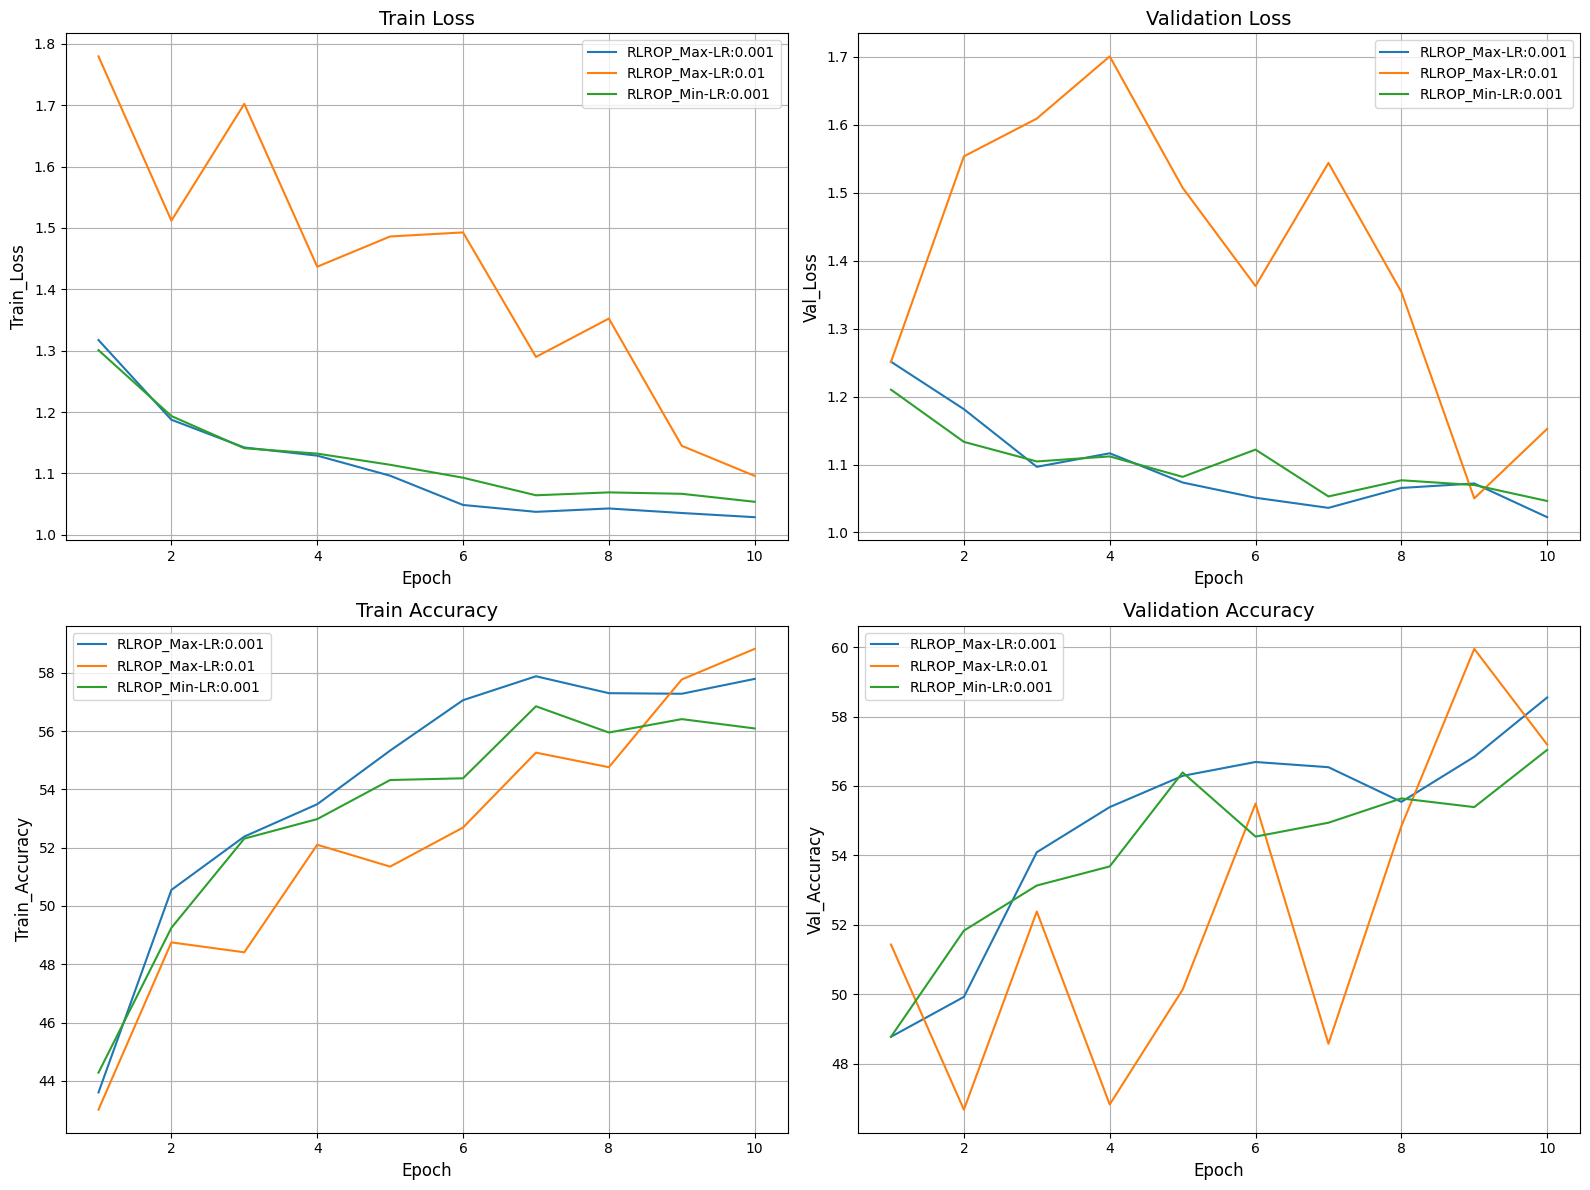

,Scheduler,LR,Epoch,Train_Loss,Train_Accuracy,Val_Loss,Val_Accuracy,Performance_Score
19,RLROP_Max,0.001,10,1.0286,57.79,1.0225,58.55,57.261614
29,RLROP_Min,0.001,10,1.0537,56.09,1.0463,57.04,54.515913
9,RLROP_Max,0.010,10,1.0959,58.82,1.1525,57.19,49.622560


In [28]:
# Recreating the dataset from the user's details
detailed_data = [
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 1, "Train_Loss": 1.7796, "Train_Accuracy": 43.01, "Val_Loss": 1.2510, "Val_Accuracy": 51.43},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 2, "Train_Loss": 1.5119, "Train_Accuracy": 48.75, "Val_Loss": 1.5533, "Val_Accuracy": 46.67},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 3, "Train_Loss": 1.7022, "Train_Accuracy": 48.41, "Val_Loss": 1.6089, "Val_Accuracy": 52.38},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 4, "Train_Loss": 1.4368, "Train_Accuracy": 52.10, "Val_Loss": 1.7004, "Val_Accuracy": 46.82},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 5, "Train_Loss": 1.4861, "Train_Accuracy": 51.35, "Val_Loss": 1.5071, "Val_Accuracy": 50.13},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 6, "Train_Loss": 1.4927, "Train_Accuracy": 52.69, "Val_Loss": 1.3625, "Val_Accuracy": 55.49},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 7, "Train_Loss": 1.2898, "Train_Accuracy": 55.26, "Val_Loss": 1.5437, "Val_Accuracy": 48.57},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 8, "Train_Loss": 1.3523, "Train_Accuracy": 54.76, "Val_Loss": 1.3539, "Val_Accuracy": 54.84},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 9, "Train_Loss": 1.1449, "Train_Accuracy": 57.77, "Val_Loss": 1.0502, "Val_Accuracy": 59.95},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 10, "Train_Loss": 1.0959, "Train_Accuracy": 58.82, "Val_Loss": 1.1525, "Val_Accuracy": 57.19},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3173, "Train_Accuracy": 43.60, "Val_Loss": 1.2512, "Val_Accuracy": 48.77},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 2, "Train_Loss": 1.1874, "Train_Accuracy": 50.55, "Val_Loss": 1.1814, "Val_Accuracy": 49.92},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 3, "Train_Loss": 1.1422, "Train_Accuracy": 52.38, "Val_Loss": 1.0966, "Val_Accuracy": 54.09},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 4, "Train_Loss": 1.1289, "Train_Accuracy": 53.49, "Val_Loss": 1.1165, "Val_Accuracy": 55.39},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 5, "Train_Loss": 1.0962, "Train_Accuracy": 55.33, "Val_Loss": 1.0735, "Val_Accuracy": 56.29},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 6, "Train_Loss": 1.0485, "Train_Accuracy": 57.06, "Val_Loss": 1.0511, "Val_Accuracy": 56.69},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 7, "Train_Loss": 1.0373, "Train_Accuracy": 57.88, "Val_Loss": 1.0362, "Val_Accuracy": 56.54},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 8, "Train_Loss": 1.0428, "Train_Accuracy": 57.30, "Val_Loss": 1.0655, "Val_Accuracy": 55.54},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 9, "Train_Loss": 1.0354, "Train_Accuracy": 57.28, "Val_Loss": 1.0721, "Val_Accuracy": 56.84},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.0286, "Train_Accuracy": 57.79, "Val_Loss": 1.0225, "Val_Accuracy": 58.55},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3008, "Train_Accuracy": 44.28, "Val_Loss": 1.2101, "Val_Accuracy": 48.77},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 2, "Train_Loss": 1.1934, "Train_Accuracy": 49.25, "Val_Loss": 1.1333, "Val_Accuracy": 51.83},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 3, "Train_Loss": 1.1410, "Train_Accuracy": 52.31, "Val_Loss": 1.1045, "Val_Accuracy": 53.13},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 4, "Train_Loss": 1.1322, "Train_Accuracy": 52.98, "Val_Loss": 1.1119, "Val_Accuracy": 53.68},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 5, "Train_Loss": 1.1140, "Train_Accuracy": 54.32, "Val_Loss": 1.0818, "Val_Accuracy": 56.39},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 6, "Train_Loss": 1.0929, "Train_Accuracy": 54.38, "Val_Loss": 1.1219, "Val_Accuracy": 54.54},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 7, "Train_Loss": 1.0643, "Train_Accuracy": 56.85, "Val_Loss": 1.0530, "Val_Accuracy": 54.94},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 8, "Train_Loss": 1.0690, "Train_Accuracy": 55.95, "Val_Loss": 1.0768, "Val_Accuracy": 55.64},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 9, "Train_Loss": 1.0667, "Train_Accuracy": 56.41, "Val_Loss": 1.0698, "Val_Accuracy": 55.39},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.0537, "Train_Accuracy": 56.09, "Val_Loss": 1.0463, "Val_Accuracy": 57.04},
]

# Convert to DataFrame
detailed_df = pd.DataFrame(detailed_data)

# Visualize metrics for all epochs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ["Train_Loss", "Val_Loss", "Train_Accuracy", "Val_Accuracy"]
titles = ["Train Loss", "Validation Loss", "Train Accuracy", "Validation Accuracy"]

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    for (scheduler, lr), group in detailed_df.groupby(["Scheduler", "LR"]):
        label = f"{scheduler}-LR:{lr}"
        ax.plot(group["Epoch"], group[metric], label=label)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.legend(loc="best", fontsize=10)
    ax.grid()

plt.tight_layout()
plt.show()

# Evaluate performance based on the 10th epoch
performance_10th_epoch = detailed_df[detailed_df["Epoch"] == 10].copy()
performance_10th_epoch["Performance_Score"] = (1 / performance_10th_epoch["Val_Loss"]) * performance_10th_epoch["Val_Accuracy"]

# Sort by performance score
performance_sorted = performance_10th_epoch.sort_values(by="Performance_Score", ascending=False)
performance_sorted

### Results for 20.000 Data

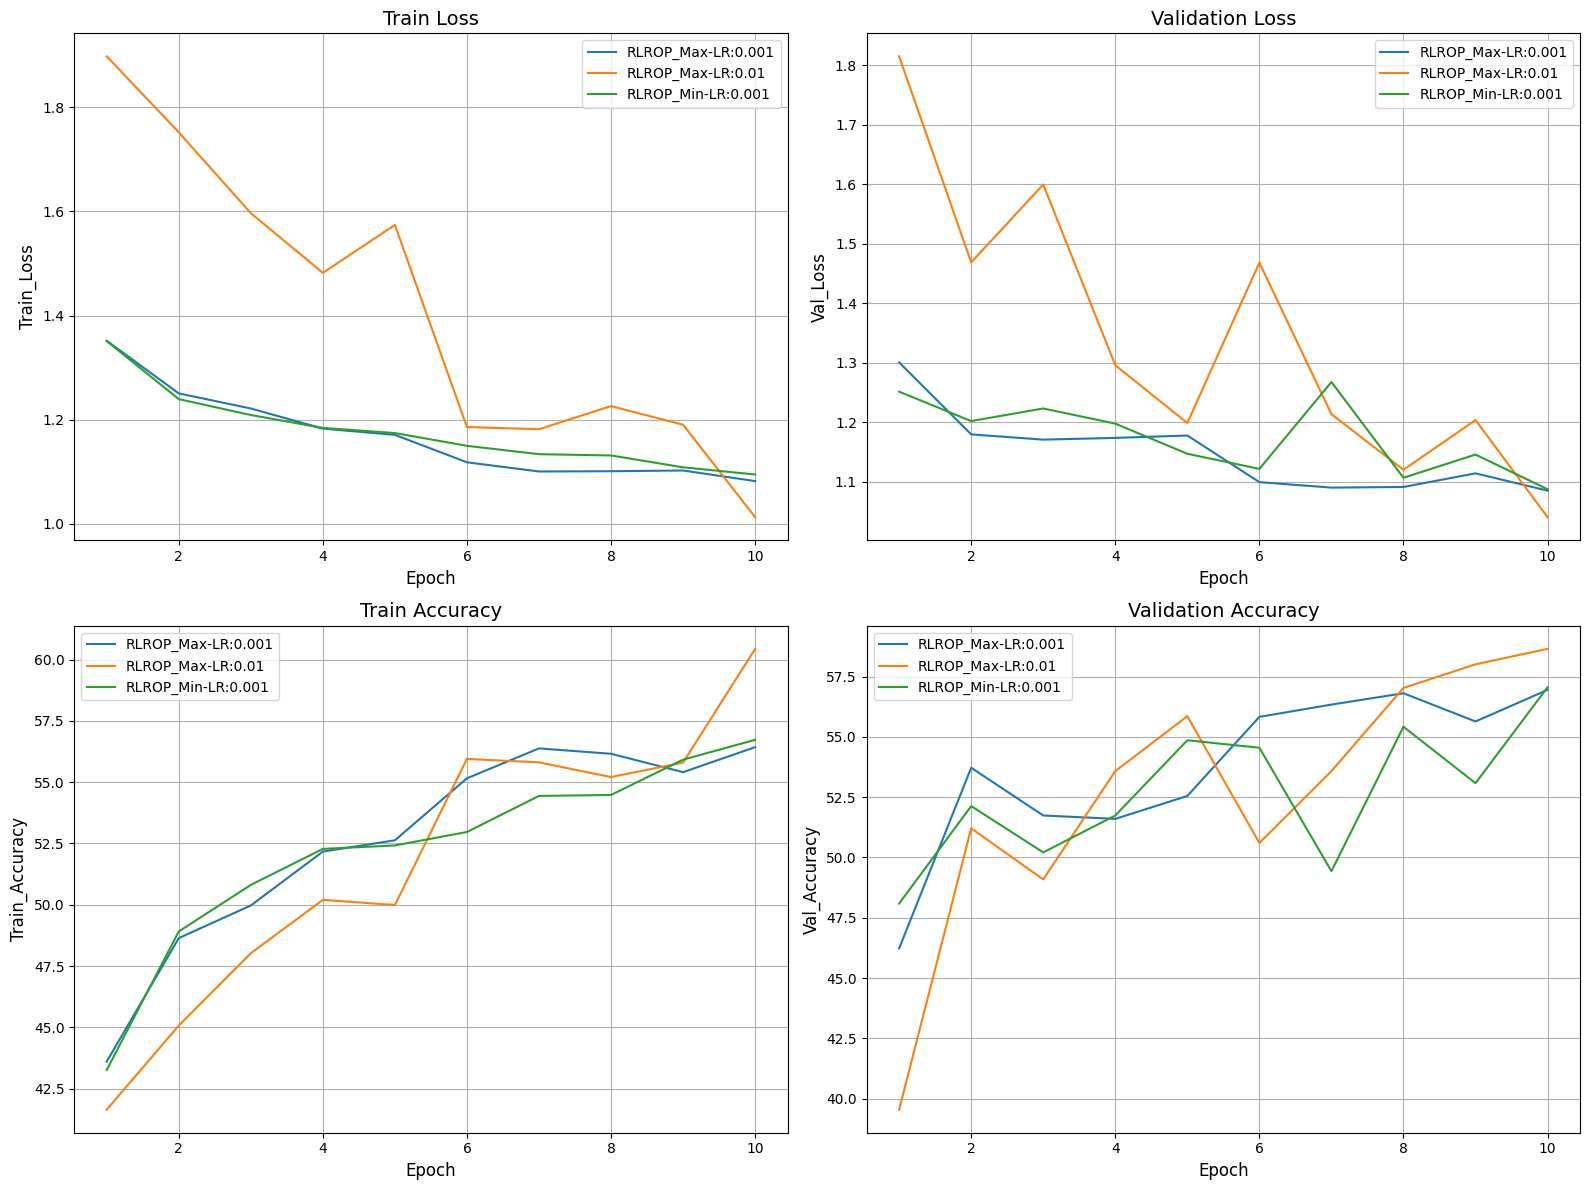

,Scheduler,LR,Epoch,Train_Loss,Train_Accuracy,Val_Loss,Val_Accuracy,Performance_Score
9,RLROP_Max,0.010,10,1.0127,60.44,1.0401,58.65,56.388809
19,RLROP_Max,0.001,10,1.0820,56.43,1.0847,56.95,52.502996
29,RLROP_Min,0.001,10,1.0947,56.73,1.0870,57.06,52.493100


In [3]:
# Recreate the detailed data
detailed_data = [
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 1, "Train_Loss": 1.8980, "Train_Accuracy": 41.64, "Val_Loss": 1.8149, "Val_Accuracy": 39.54},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 2, "Train_Loss": 1.7521, "Train_Accuracy": 45.07, "Val_Loss": 1.4685, "Val_Accuracy": 51.21},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 3, "Train_Loss": 1.5968, "Train_Accuracy": 48.02, "Val_Loss": 1.5994, "Val_Accuracy": 49.09},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 4, "Train_Loss": 1.4821, "Train_Accuracy": 50.20, "Val_Loss": 1.2956, "Val_Accuracy": 53.58},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 5, "Train_Loss": 1.5742, "Train_Accuracy": 49.99, "Val_Loss": 1.1984, "Val_Accuracy": 55.86},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 6, "Train_Loss": 1.1859, "Train_Accuracy": 55.95, "Val_Loss": 1.4681, "Val_Accuracy": 50.60},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 7, "Train_Loss": 1.1817, "Train_Accuracy": 55.81, "Val_Loss": 1.2133, "Val_Accuracy": 53.58},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 8, "Train_Loss": 1.2261, "Train_Accuracy": 55.21, "Val_Loss": 1.1198, "Val_Accuracy": 57.03},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 9, "Train_Loss": 1.1903, "Train_Accuracy": 55.80, "Val_Loss": 1.2034, "Val_Accuracy": 58.01},
    {"Scheduler": "RLROP_Max", "LR": 0.010, "Epoch": 10, "Train_Loss": 1.0127, "Train_Accuracy": 60.44, "Val_Loss": 1.0401, "Val_Accuracy": 58.65},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3516, "Train_Accuracy": 43.60, "Val_Loss": 1.3003, "Val_Accuracy": 46.23},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 2, "Train_Loss": 1.2505, "Train_Accuracy": 48.64, "Val_Loss": 1.1793, "Val_Accuracy": 53.72},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 3, "Train_Loss": 1.2215, "Train_Accuracy": 49.97, "Val_Loss": 1.1705, "Val_Accuracy": 51.74},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 4, "Train_Loss": 1.1828, "Train_Accuracy": 52.17, "Val_Loss": 1.1734, "Val_Accuracy": 51.60},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 5, "Train_Loss": 1.1709, "Train_Accuracy": 52.63, "Val_Loss": 1.1774, "Val_Accuracy": 52.55},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 6, "Train_Loss": 1.1181, "Train_Accuracy": 55.16, "Val_Loss": 1.0990, "Val_Accuracy": 55.83},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 7, "Train_Loss": 1.1005, "Train_Accuracy": 56.38, "Val_Loss": 1.0898, "Val_Accuracy": 56.34},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 8, "Train_Loss": 1.1010, "Train_Accuracy": 56.16, "Val_Loss": 1.0909, "Val_Accuracy": 56.81},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 9, "Train_Loss": 1.1024, "Train_Accuracy": 55.41, "Val_Loss": 1.1138, "Val_Accuracy": 55.64},
    {"Scheduler": "RLROP_Max", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.0820, "Train_Accuracy": 56.43, "Val_Loss": 1.0847, "Val_Accuracy": 56.95},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 1, "Train_Loss": 1.3510, "Train_Accuracy": 43.26, "Val_Loss": 1.2511, "Val_Accuracy": 48.09},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 2, "Train_Loss": 1.2395, "Train_Accuracy": 48.91, "Val_Loss": 1.2017, "Val_Accuracy": 52.13},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 3, "Train_Loss": 1.2090, "Train_Accuracy": 50.81, "Val_Loss": 1.2229, "Val_Accuracy": 50.21},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 4, "Train_Loss": 1.1842, "Train_Accuracy": 52.28, "Val_Loss": 1.1974, "Val_Accuracy": 51.74},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 5, "Train_Loss": 1.1743, "Train_Accuracy": 52.42, "Val_Loss": 1.1467, "Val_Accuracy": 54.86},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 6, "Train_Loss": 1.1498, "Train_Accuracy": 52.97, "Val_Loss": 1.1213, "Val_Accuracy": 54.55},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 7, "Train_Loss": 1.1337, "Train_Accuracy": 54.44, "Val_Loss": 1.2673, "Val_Accuracy": 49.43},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 8, "Train_Loss": 1.1313, "Train_Accuracy": 54.48, "Val_Loss": 1.1064, "Val_Accuracy": 55.42},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 9, "Train_Loss": 1.1085, "Train_Accuracy": 55.92, "Val_Loss": 1.1454, "Val_Accuracy": 53.08},
    {"Scheduler": "RLROP_Min", "LR": 0.001, "Epoch": 10, "Train_Loss": 1.0947, "Train_Accuracy": 56.73, "Val_Loss": 1.0870, "Val_Accuracy": 57.06},
]

# Convert to DataFrame
detailed_df = pd.DataFrame(detailed_data)

# Visualize metrics for all epochs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ["Train_Loss", "Val_Loss", "Train_Accuracy", "Val_Accuracy"]
titles = ["Train Loss", "Validation Loss", "Train Accuracy", "Validation Accuracy"]

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    for (scheduler, lr), group in detailed_df.groupby(["Scheduler", "LR"]):
        label = f"{scheduler}-LR:{lr}"
        ax.plot(group["Epoch"], group[metric], label=label)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.legend(loc="best", fontsize=10)
    ax.grid()

plt.tight_layout()
plt.show()

# Evaluate performance based on the 10th epoch
performance_10th_epoch = detailed_df[detailed_df["Epoch"] == 10].copy()
performance_10th_epoch["Performance_Score"] = (1 / performance_10th_epoch["Val_Loss"]) * performance_10th_epoch["Val_Accuracy"]

# Sort by performance score
performance_sorted = performance_10th_epoch.sort_values(by="Performance_Score", ascending=False)
performance_sorted 

# Training with best configuration

In [85]:
criterion_CEL = nn.CrossEntropyLoss()
criterion_CEL = criterion_CEL.to('cuda')
model = EmotionDetectionModel(num_classes=5)
model.to('cuda')
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
train_model(optimizer,criterion_CEL, scheduler, model, f"scheduler RLROP_Max / LR {0.01:.3f}")

scheduler RLROP_Max / LR 0.010
Epoch [1/10] , [1.3741223530769349]
  Train Loss: 1.3741, Accuracy: 46.17%, Precision: 0.46, Recall: 0.46, F1-Score: 0.46
  Val Loss: 1.1324, Accuracy: 52.08%, Precision: 0.62, Recall: 0.52, F1-Score: 0.51
Epoch [2/10] , [1.3741223530769349, 0.8787581114768982]
  Train Loss: 0.8788, Accuracy: 64.49%, Precision: 0.64, Recall: 0.64, F1-Score: 0.64
  Val Loss: 0.8490, Accuracy: 67.22%, Precision: 0.69, Recall: 0.67, F1-Score: 0.67
Epoch [3/10] , [1.3741223530769349, 0.8787581114768982, 0.6421078178882599]
  Train Loss: 0.6421, Accuracy: 75.27%, Precision: 0.75, Recall: 0.75, F1-Score: 0.75
  Val Loss: 0.8628, Accuracy: 68.32%, Precision: 0.72, Recall: 0.68, F1-Score: 0.68
Epoch [4/10] , [1.3741223530769349, 0.8787581114768982, 0.6421078178882599, 0.46274130427837373]
  Train Loss: 0.4627, Accuracy: 82.70%, Precision: 0.83, Recall: 0.83, F1-Score: 0.83
  Val Loss: 0.8829, Accuracy: 70.68%, Precision: 0.74, Recall: 0.71, F1-Score: 0.70
Epoch [5/10] , [1.374122

In [88]:
torch.save(model.state_dict(), 'emotion_detection_model.pth')

In [ ]:
# Epochs
epochs = np.arange(1, 11)

# 2x2 Graph Layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Loss (Train vs Validation)
axes[0, 0].plot(epochs, train_losses, label='Train Loss')
axes[0, 0].plot(epochs, val_losses, label='Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Train vs Validation Loss')

# 2. Accuracy (Train vs Validation)
axes[0, 1].plot(epochs, train_accuracies, label='Train Accuracy')
axes[0, 1].plot(epochs, val_accuracies, label='Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Train vs Validation Accuracy')

# 3. F1 Score (Train vs Validation)
axes[1, 0].plot(epochs, train_f1_scores, label='Train F1-Score')
axes[1, 0].plot(epochs, val_f1_scores, label='Validation F1-Score')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].legend()
axes[1, 0].set_title('Train vs Validation F1-Score')

# 4. Confusion Matrix
conf_matrix = confusion_matrix(all_labels_final[0], all_preds_final[0])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(ax=axes[1, 1], cmap=plt.cm.Blues)
axes[1, 1].set_title('Confusion Matrix')

# show plot
plt.tight_layout()
plt.show()

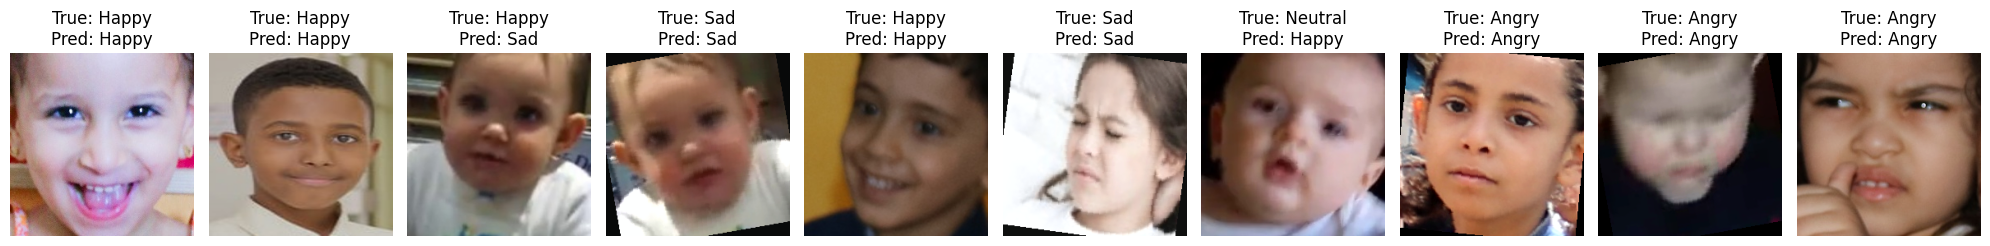

In [87]:
# Function to visualize test results for 10 random samples
def visualize_test_results(model, dataset, class_names, num_samples=10):
    model.eval()
    random_indices = random.sample(range(len(dataset)), num_samples)  # Randomly select indices
    images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for idx in random_indices:
            image, label = dataset[idx]
            images.append(image)
            true_labels.append(label)

            # Model prediction
            image = image.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_labels.append(predicted.item())

    # Plot the images with predictions and true labels
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
        image = image.clip(0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
visualize_test_results(model, val_dataset, class_names, num_samples=10)


# GRAD-Cam

In [ ]:
# Grad-CAM
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def _init_(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # catch activations and gradients
        def forward_hook(module, input, output):
            self.activations = output
            print(f"Activations Shape: {self.activations.shape}")

        # catch gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
            if self.gradients is not None:
                print(f"Gradients Shape: {self.gradients.shape}")
            else:
                print("Gradients are None!")

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)
        print(f"Output Shape: {output.shape}")

        # Backward pass
        self.model.zero_grad()
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)

        # Check gradients and activations
        if self.gradients is None:
            raise ValueError("Gradients are not captured. Check hooks and backward pass.")
        if self.activations is None:
            raise ValueError("Activations are not captured. Check forward pass.")

        # Compute weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        print(f"Weights Shape: {weights.shape}, Weights Sum: {weights.sum()}")

        # Weighted activations
        weighted_activations = weights * self.activations
        print(f"Weighted Activations Sum: {weighted_activations.sum()}")
        print(f"Weighted Activations Shape: {weighted_activations.shape}")

        # Generate CAM
        cam = torch.sum(weighted_activations, dim=1)
        print(f"CAM After Sum Shape: {cam.shape}, Sum: {cam.sum()}")

        cam = cam.squeeze()
        print(f"CAM After Squeeze Shape: {cam.shape}, Sum: {cam.sum()}")

        # ReLU
        cam = torch.relu(cam)
        print(f"CAM After ReLU Min: {cam.min()}, Max: {cam.max()}")

        # Normalization
        if cam.max() > 0:
            cam = cam / cam.max()
        else:
            print("CAM max value is 0, normalization skipped.")

        print(f"CAM Normalized Min: {cam.min()}, Max: {cam.max()}")
        return cam.cpu().detach().numpy()


# model and target layer
model = EmotionDetectionModel(num_classes=5)
model.load_state_dict(torch.load('emotion_detection_model.pth'))
model = model.to('cuda')
model.eval()
target_layer = model.resnet.layer4  # example target layer


# path to example image
image_path = "asd_01.jpg" 

# load image
img = Image.open(image_path).convert('RGB')

# transformations, preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # proper size for ResNet
    transforms.ToTensor(),          # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

input_tensor = transform(img).unsqueeze(0).to('cuda')

# object creation
grad_cam = GradCAM(model, target_layer=model.resnet.layer4)  # target layer is the last layer of ResNet

# label mapping
label_mapping = {0: 'happy', 1: 'sad', 2: 'angry', 3: 'surprised', 4: 'neutral'}

# generate CAM for each label
for target_class, label_name in label_mapping.items():
    cam = grad_cam.generate(input_tensor, target_class)

    # create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # convert to RGB format

    # resize heatmap to the same size as the input image
    heatmap = cv2.resize(heatmap, (224, 224))

    # superimpose heatmap onto the original image
    alpha = 0.5  # transparency factor
    superimposed_img = cv2.addWeighted(np.array(img.resize((224, 224))), 1 - alpha, heatmap, alpha, 0)

    # plot images
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Grad-CAM Visualization for {label_name}")

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Grad-CAM Superimposed")
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()